# Sea Surface Current Prediction using LSTM

This notebook outlines the process of loading, inspecting, and preprocessing sea surface current data (`u` and `v` components) for training an LSTM model. The goal is to predict sea surface currents for the next 24 hours based on historical data.

### Import Libraries

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches
import matplotlib.path as mpath
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, InputLayer, Masking
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.losses import MeanSquaredError
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.models import load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

### Load and Inspect Data

The initial step involves loading the dataset using xarray, which facilitates working with multi-dimensional arrays, and inspecting its structure to understand the available dimensions, coordinates, and variables.

In [2]:
# Load the dataset
netcdf_file_path = "Data/24_months_SSC_Data.nc"

# Open the data
dataset = xr.open_dataset(netcdf_file_path)

# Print head of dataset
dataset.head()

<xarray.Dataset>
Dimensions:  (time: 5, lat: 5, lon: 5)
Coordinates:
  * time     (time) datetime64[ns] 2021-01-01 ... 2021-01-01T04:00:00
  * lat      (lat) float32 35.74 35.77 35.79 35.81 35.83
  * lon      (lon) float32 13.68 13.72 13.76 13.8 13.84
Data variables:
    u        (time, lat, lon) float64 ...
    v        (time, lat, lon) float64 ...
    stdu     (time, lat, lon) float64 ...
    stdv     (time, lat, lon) float64 ...
    cov      (time, lat, lon) float64 ...
    velo     (time, lat, lon) float64 ...
    head     (time, lat, lon) float64 ...
Attributes: (12/17)
    NC_GLOBAL.Title:                   Near-Real time Surface Ocean Velocity
    NC_GLOBAL.origin:                  BARK (measured);POZZ (measured);
    NC_GLOBAL.source:                  HF Radar Derived Surface Currents obta...
    NC_GLOBAL.history:                 08-Jun-2023 14:45:58
    NC_GLOBAL.grid_type:               REGULAR
    NC_GLOBAL.Conventions:             CF-1.4
    ...                                ...
    NC_GLOBAL.grid_resolution:         3.0km
    NC_GLOBAL.geospatial_lat_max:      36.8802
    NC_GLOBAL.geospatial_lat_min:      35.7447
    NC_GLOBAL.geospatial_lon_max:      15.3804
    NC_GLOBAL.geospatial_lon_min:      13.6768
    NC_GLOBAL.netcdf_library_version:  v2

### Convert the dataset to a pandas DataFrame

In [3]:
# Convert the dataset to a pandas DataFrame
df = dataset.to_dataframe().reset_index()

# Drop columns from the DataFrame
df = df.drop(columns=['stdu', 'stdv', 'cov', 'velo', 'head'])

# Convert 'u' and 'v' from float64 to float32 to save memory
df['u'] = df['u'].astype('float32')
df['v'] = df['v'].astype('float32')

# Calculate mean values for 'u' and 'v', ignoring NaNs
mean_u = df['u'].mean()
mean_v = df['v'].mean()

# Replace NaN values with the computed means
df['u'].fillna(mean_u, inplace=True)
df['v'].fillna(mean_v, inplace=True)

df.index = pd.to_datetime(df['time'], format='%d-%m-%Y %H:%M:%S')

df

,time,lat,lon,u,v
time,,,,,
2021-01-01 00:00:00,2021-01-01 00:00:00,35.744701,13.6768,0.121938,-0.098121
2021-01-01 00:00:00,2021-01-01 00:00:00,35.744701,13.7174,0.121938,-0.098121
2021-01-01 00:00:00,2021-01-01 00:00:00,35.744701,13.7579,0.121938,-0.098121
2021-01-01 00:00:00,2021-01-01 00:00:00,35.744701,13.7985,0.121938,-0.098121
2021-01-01 00:00:00,2021-01-01 00:00:00,35.744701,13.8390,0.121938,-0.098121
...,...,...,...,...,...
2022-12-31 23:00:00,2022-12-31 23:00:00,36.880199,15.2182,0.121938,-0.098121
2022-12-31 23:00:00,2022-12-31 23:00:00,36.880199,15.2587,0.121938,-0.098121
2022-12-31 23:00:00,2022-12-31 23:00:00,36.880199,15.2993,0.121938,-0.098121


### Geospatial Visualization
Define boundaries and coordinates for visualization

In [4]:
# Define the boundaries for map
boundaries = {
    'min_lon': 14.15,  
    'max_lon': 14.65,  
    'min_lat': 35.79,  
    'max_lat': 36.15   
}

# Define the coordinates 
polygon_coordinates = [
    (14.6, 35.87), 
    (14.35, 36.01), 
    (14.35, 36.09), 
    (14.6, 36.09), 
    (14.6, 35.87)
]

# # Create a plot with Cartopy
# fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
# ax.set_extent([boundaries['min_lon'], boundaries['max_lon'], boundaries['min_lat'], boundaries['max_lat']], crs=ccrs.PlateCarree())

# # Add map features
# ax.add_feature(cfeature.LAND)
# ax.add_feature(cfeature.COASTLINE)
# ax.add_feature(cfeature.BORDERS, linestyle=':')

# # Plotting all points within the boundary from the dataframe 'df'
# ax.scatter(df['lon'], df['lat'], s=10, color='blue', marker='o', alpha=0.5, transform=ccrs.Geodetic())

# # Create a red polygon and add it to the plot
# red_polygon = mpatches.Polygon(polygon_coordinates, closed=True, edgecolor='red', facecolor='none', linewidth=3, transform=ccrs.Geodetic())
# ax.add_patch(red_polygon)

# # Gridlines and labels
# gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
# gl.top_labels = False
# gl.right_labels = False

# plt.show()

### Data Filtering 
Filter the DataFrame to include only data points within the specified polygon.

In [5]:
# # Convert the polygon coordinates to a Path object
# polygon_path = mpath.Path(polygon_coordinates)

# # Use the Path object to find points inside the polygon
# inside_polygon = df.apply(lambda row: polygon_path.contains_point((row['lon'], row['lat'])), axis=1)
# df_inside_polygon = df[inside_polygon]

# # Create a plot with Cartopy
# fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
# ax.set_extent([boundaries['min_lon'], boundaries['max_lon'], boundaries['min_lat'], boundaries['max_lat']], crs=ccrs.PlateCarree())

# # Add map features
# ax.add_feature(cfeature.LAND)
# ax.add_feature(cfeature.COASTLINE)
# ax.add_feature(cfeature.BORDERS, linestyle=':')

# # Plotting only the points within the polygon
# ax.scatter(df_inside_polygon['lon'], df_inside_polygon['lat'], s=10, color='red', marker='x', alpha=0.5, transform=ccrs.Geodetic())

# # Gridlines and labels
# gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
# gl.top_labels = False
# gl.right_labels = False

# plt.show()

### Data Preparation

In [6]:
# # Convert the polygon coordinates to a Path object
# polygon_path = mpath.Path(polygon_coordinates)

# # Prepare the coordinates as a list of tuples
# coordinates = list(zip(df['lon'], df['lat']))

# # Check if each coordinate is inside the polygon
# inside_mask = [polygon_path.contains_point(coord) for coord in coordinates]

# # Filter the DataFrame for points within the polygon
# df_inside_polygon = df[inside_mask]

# # Removing potential duplicates
# df_inside_polygon = df_inside_polygon.drop_duplicates(subset=['lon', 'lat'])

# # Count the number of points inside the polygon
# num_points_inside_polygon = df_inside_polygon.shape[0]
# print(f"Total number of points inside the polygon: {num_points_inside_polygon}\n")
# print("Coordinates of the points inside the polygon:")

# # Print out all of the coordinate pairs
# coordinates_inside = df_inside_polygon[['lon', 'lat']].values
# for lon, lat in coordinates_inside:
#     print(f"({lon}, {lat})")

In [7]:
# # Assuming 'inside_mask' is a list of booleans indicating whether each point is inside the polygon
# inside_mask = [polygon_path.contains_point((lon, lat)) for lon, lat in zip(df['lon'], df['lat'])]

# # Convert 'inside_mask' to a pandas Series to use as a boolean indexer
# inside_series = pd.Series(inside_mask, index=df.index)

# # Filter the original DataFrame using the boolean Series
# final_df = df[inside_series]

# # Display the resulting DataFrame
# final_df

### Exctract data only for a single pair of coordinates

In [8]:
# Coordinates 
target_lat = 36.03409957885742
target_lon = 14.528599739074707

# Filter the DataFrame for the exact coordinates
# df_point = final_df[(final_df['lat'] == target_lat) & (final_df['lon'] == target_lon)]
df_point = df[(df['lat'] == target_lat) & (df['lon'] == target_lon)]

# Display the filtered DataFrame
df_point

,time,lat,lon,u,v
time,,,,,
2021-01-01 00:00:00,2021-01-01 00:00:00,36.0341,14.5286,0.079402,0.039575
2021-01-01 01:00:00,2021-01-01 01:00:00,36.0341,14.5286,0.121938,-0.098121
2021-01-01 02:00:00,2021-01-01 02:00:00,36.0341,14.5286,0.121938,-0.098121
2021-01-01 03:00:00,2021-01-01 03:00:00,36.0341,14.5286,0.121938,-0.098121
2021-01-01 04:00:00,2021-01-01 04:00:00,36.0341,14.5286,0.121938,-0.098121
...,...,...,...,...,...
2022-12-31 19:00:00,2022-12-31 19:00:00,36.0341,14.5286,0.003522,-0.170710
2022-12-31 20:00:00,2022-12-31 20:00:00,36.0341,14.5286,0.000774,-0.120463
2022-12-31 21:00:00,2022-12-31 21:00:00,36.0341,14.5286,-0.030468,-0.092138


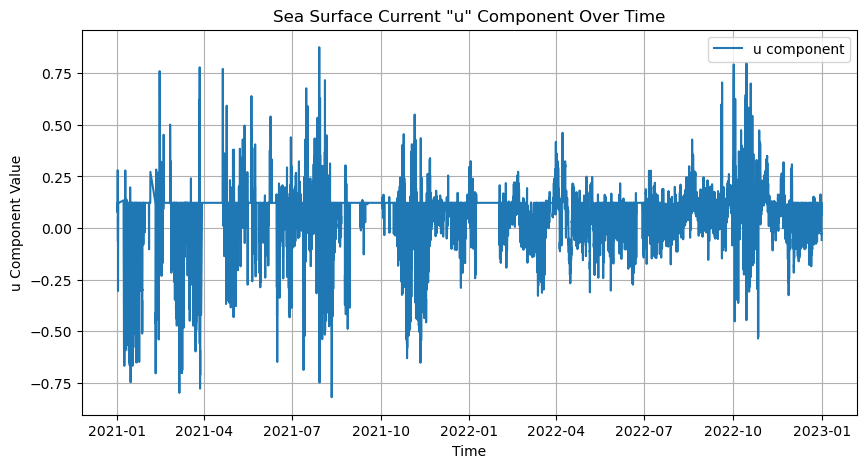

In [9]:
df1_u = df_point['u']

plt.figure(figsize=(10, 5))  
plt.plot(df1_u.index, df1_u, label='u component')  
plt.title('Sea Surface Current "u" Component Over Time')  
plt.xlabel('Time')  
plt.ylabel('u Component Value')  
plt.legend()  
plt.grid(True)  
plt.show()

### Convert the time series data into a format suitable for LSTM

In [11]:
window_size = 72

def df_to_X_y_72h(df_u, df_v, window_size=window_size, forecast_horizon=24):
    df_u_as_np = df_u.to_numpy()
    df_v_as_np = df_v.to_numpy()
    X = [] 
    y = []
    for i in range(len(df_u_as_np) - window_size - forecast_horizon + 1):
        combined_features = [[df_u_as_np[i+j], df_v_as_np[i+j]] for j in range(window_size)]
        X.append(combined_features)
        label = df_u_as_np[i + window_size:i + window_size + forecast_horizon]
        y.append(label)
    return np.array(X), np.array(y)

X, y = df_to_X_y_72h(df_point['u'], df_point['v'], window_size=window_size)
X.shape, y.shape

((16389, 72, 2), (16389, 24))

### Split the data

In [12]:
def train_val_test_split(X, y, train_size, val_size, test_size):
    # Calculate the indices for the end of each segment
    total_size = len(X)
    train_end = int(total_size * train_size)
    val_end = train_end + int(total_size * val_size)
    
    # Split the data
    X_train = X[:train_end]
    y_train = y[:train_end]
    
    X_val = X[train_end:val_end]
    y_val = y[train_end:val_end]
    
    X_test = X[val_end:]
    y_test = y[val_end:]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

train_size = 0.70
val_size = 0.15
test_size = 1 - (train_size + val_size)

X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(X, y, train_size, val_size, test_size)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((11472, 72, 2),
 (11472, 24),
 (2458, 72, 2),
 (2458, 24),
 (2459, 72, 2),
 (2459, 24))

### Define & Compile the Model

In [13]:
# Define the model
model = Sequential()
model.add(InputLayer(input_shape=(window_size, 2)))
model.add(LSTM(256, return_sequences=True))  # Increased complexity with more units
model.add(Dropout(0.3))  # Slightly increased dropout rate
model.add(LSTM(128, return_sequences=True))  # Additional LSTM layer for complexity
model.add(Dropout(0.3))  # Adjusting dropout rate
model.add(LSTM(64))  # Last LSTM layer without return_sequences to prepare for dense layer
model.add(Dropout(0.3))  # Consistent dropout rate for regularization
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))  # Increased units in dense layer
model.add(Dense(24, activation='linear'))  # Output layer for 24-hour forecast

model.summary()

# Define ModelCheckpoint callback to save the best model
model_checkpoint = ModelCheckpoint(filepath="Data/LSTM/Saved_Models/lstm_test",
                     save_best_only=True,
                     monitor='val_loss',  
                     mode='min',
                     verbose=0)   

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=8,
                               restore_best_weights=True,
                               min_delta=0.0001,  
                               verbose=1)             

# Compile the model
model.compile(loss=MeanSquaredError(),
              optimizer=Adam(learning_rate=0.0001))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 72, 256)           265216    
                                                                 
 dropout (Dropout)           (None, 72, 256)           0         
                                                                 
 lstm_1 (LSTM)               (None, 72, 128)           197120    
                                                                 
 dropout_1 (Dropout)         (None, 72, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 32)                

### Train the Model

Epoch 1/100

359/359 [==============================] - ETA: 0s - loss: 0.3606INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_test\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_test\assets


359/359 [==============================] - 131s 334ms/step - loss: 0.3606 - val_loss: 0.2779
Epoch 2/100
359/359 [==============================] - ETA: 0s - loss: 0.2356INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_test\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_test\assets


359/359 [==============================] - 105s 292ms/step - loss: 0.2356 - val_loss: 0.1776
Epoch 3/100
359/359 [==============================] - ETA: 0s - loss: 0.1531INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_test\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_test\assets


359/359 [==============================] - 104s 291ms/step - loss: 0.1531 - val_loss: 0.1111
Epoch 4/100
359/359 [==============================] - ETA: 0s - loss: 0.0987INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_test\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_test\assets


359/359 [==============================] - 122s 339ms/step - loss: 0.0987 - val_loss: 0.0679
Epoch 5/100
359/359 [==============================] - ETA: 0s - loss: 0.0637INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_test\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_test\assets


359/359 [==============================] - 139s 387ms/step - loss: 0.0637 - val_loss: 0.0404
Epoch 6/100
359/359 [==============================] - ETA: 0s - loss: 0.0420INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_test\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_test\assets


359/359 [==============================] - 128s 358ms/step - loss: 0.0420 - val_loss: 0.0240
Epoch 7/100
359/359 [==============================] - ETA: 0s - loss: 0.0292INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_test\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_test\assets


359/359 [==============================] - 128s 356ms/step - loss: 0.0292 - val_loss: 0.0147
Epoch 8/100
359/359 [==============================] - ETA: 0s - loss: 0.0222INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_test\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_test\assets


359/359 [==============================] - 140s 390ms/step - loss: 0.0222 - val_loss: 0.0098
Epoch 9/100
359/359 [==============================] - ETA: 0s - loss: 0.0186INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_test\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_test\assets


359/359 [==============================] - 157s 437ms/step - loss: 0.0186 - val_loss: 0.0076
Epoch 10/100
359/359 [==============================] - ETA: 0s - loss: 0.0169INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_test\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_test\assets


359/359 [==============================] - 173s 482ms/step - loss: 0.0169 - val_loss: 0.0067
Epoch 11/100
359/359 [==============================] - ETA: 0s - loss: 0.0161INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_test\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_test\assets


359/359 [==============================] - 137s 382ms/step - loss: 0.0161 - val_loss: 0.0063
Epoch 12/100
359/359 [==============================] - ETA: 0s - loss: 0.0157INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_test\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_test\assets


359/359 [==============================] - 157s 437ms/step - loss: 0.0157 - val_loss: 0.0061
Epoch 13/100
359/359 [==============================] - 125s 348ms/step - loss: 0.0155 - val_loss: 0.0061
Epoch 14/100
359/359 [==============================] - ETA: 0s - loss: 0.0154INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_test\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_test\assets


359/359 [==============================] - 74s 207ms/step - loss: 0.0154 - val_loss: 0.0060
Epoch 15/100
359/359 [==============================] - 74s 206ms/step - loss: 0.0152 - val_loss: 0.0061
Epoch 16/100
359/359 [==============================] - 68s 190ms/step - loss: 0.0149 - val_loss: 0.0062
Epoch 17/100
359/359 [==============================] - 71s 197ms/step - loss: 0.0148 - val_loss: 0.0060
Epoch 18/100
359/359 [==============================] - 65s 181ms/step - loss: 0.0148 - val_loss: 0.0063
Epoch 19/100
359/359 [==============================] - 66s 185ms/step - loss: 0.0144 - val_loss: 0.0062
Epoch 20/100
359/359 [==============================] - 70s 194ms/step - loss: 0.0143 - val_loss: 0.0062
Epoch 20: early stopping


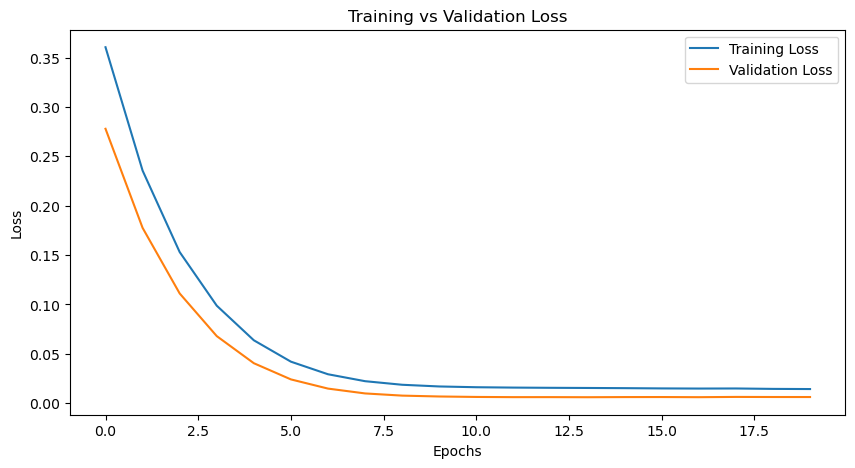

In [14]:
# Fit the model with the training data and validate with the validation data
history = model.fit(X_train, y_train,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    epochs=100,
                    callbacks=[model_checkpoint, early_stopping])

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Evaluation on Test Set

In [15]:
# Load the model
model = load_model("Data/LSTM/Saved_Models/lstm_test")

# Make predictions on the test data
test_predictions = model.predict(X_test)

print("y_test shape:", y_test.shape)
print("test_predictions shape:", test_predictions.shape)

77/77 [==============================] - 5s 58ms/step
y_test shape: (2459, 24)
test_predictions shape: (2459, 24)


In [16]:
# Calculate metrics
mse_u = mean_squared_error(y_test, test_predictions)
m_ae_u = mean_absolute_error(y_test, test_predictions)
r2_u = r2_score(y_test, test_predictions)
explained_variance_u = explained_variance_score(y_test, test_predictions)

# Output the error metrics
print("Test MSE for 'u' component:", mse_u)
print("Test MAE for 'u' component:", m_ae_u)
print("Test R-squared for 'u' component:", r2_u)
print("Test Explained Variance for 'u' component:", explained_variance_u)

Test MSE for 'u' component: 0.013719674
Test MAE for 'u' component: 0.07761531
Test R-squared for 'u' component: 0.13938518150110607
Test Explained Variance for 'u' component: 0.14678352077802023


In [17]:
test_results = pd.DataFrame({
    'Test Predictions u': test_predictions.flatten(),
    'Actuals u': y_test.flatten()
})

test_results

,Test Predictions u,Actuals u
0,0.062247,0.026336
1,0.062567,-0.147737
2,0.067033,0.121938
3,0.065655,0.121938
4,0.071025,0.121938
...,...,...
59011,0.074758,0.003522
59012,0.072580,0.000774
59013,0.065396,-0.030468
59014,0.061609,-0.026932


### Making Real-Life prediction

In [18]:
# Load input dataset
input_dataset = xr.open_dataset("Data/input_72_hours_data_SSC_Data.nc")
input_df = input_dataset.to_dataframe().reset_index()
input_df = input_df.drop(columns=['stdu', 'stdv', 'cov', 'velo', 'head'])
input_df['u'] = input_df['u'].astype('float32')
input_df['v'] = input_df['v'].astype('float32')
input_df.index = pd.to_datetime(input_df['time'], format='%d-%m-%Y %H:%M:%S')

# Calculate mean values for 'u' and 'v'
mean_u = input_df['u'].mean()
mean_v = input_df['v'].mean()

# Replace NaN values with the computed means in the filtered DataFrame
input_df['u'].fillna(mean_u, inplace=True)
input_df['v'].fillna(mean_v, inplace=True)

# Filter the DataFrame for the exact coordinates
df_point_input = input_df[(input_df['lat'] == target_lat) & (input_df['lon'] == target_lon)]

df_point_input

,time,lat,lon,u,v
time,,,,,
2023-06-01 00:00:00,2023-06-01 00:00:00,36.0341,14.5286,-0.088624,0.186460
2023-06-01 01:00:00,2023-06-01 01:00:00,36.0341,14.5286,-0.057444,0.153769
2023-06-01 02:00:00,2023-06-01 02:00:00,36.0341,14.5286,-0.037624,0.167024
2023-06-01 03:00:00,2023-06-01 03:00:00,36.0341,14.5286,-0.014970,0.145006
2023-06-01 04:00:00,2023-06-01 04:00:00,36.0341,14.5286,-0.032614,0.143056
...,...,...,...,...,...
2023-06-03 19:00:00,2023-06-03 19:00:00,36.0341,14.5286,0.058526,-0.011517
2023-06-03 20:00:00,2023-06-03 20:00:00,36.0341,14.5286,-0.029770,0.047738
2023-06-03 21:00:00,2023-06-03 21:00:00,36.0341,14.5286,-0.037362,0.002415


In [19]:
# Load actual dataset
actual_dataset = xr.open_dataset("Data/actual_24_hours_data_SSC_Data.nc")
actual_df = actual_dataset.to_dataframe().reset_index()
actual_df = actual_df.drop(columns=['stdu', 'stdv', 'cov', 'velo', 'head'])
actual_df['u'] = actual_df['u'].astype('float32')
actual_df['v'] = actual_df['v'].astype('float32')
actual_df.index = pd.to_datetime(actual_df['time'], format='%d-%m-%Y %H:%M:%S')

# Calculate mean values for 'u' and 'v', ignoring NaNs
mean_u = input_df['u'].mean()
mean_v = input_df['v'].mean()

# Replace NaN values with the computed means in the filtered DataFrame
input_df['u'].fillna(mean_u, inplace=True)
input_df['v'].fillna(mean_v, inplace=True)

# Filter the DataFrame for the exact coordinates at the target latitude and longitude
df_point_actual = actual_df[(actual_df['lat'] == target_lat) & (actual_df['lon'] == target_lon)]

df_point_actual

,time,lat,lon,u,v
time,,,,,
2023-06-04 00:00:00,2023-06-04 00:00:00,36.0341,14.5286,-0.262134,0.022713
2023-06-04 01:00:00,2023-06-04 01:00:00,36.0341,14.5286,-0.079164,0.076530
2023-06-04 02:00:00,2023-06-04 02:00:00,36.0341,14.5286,-0.047178,0.103968
2023-06-04 03:00:00,2023-06-04 03:00:00,36.0341,14.5286,-0.079376,0.110515
2023-06-04 04:00:00,2023-06-04 04:00:00,36.0341,14.5286,-0.068955,0.122259
2023-06-04 05:00:00,2023-06-04 05:00:00,36.0341,14.5286,-0.095685,0.113974
2023-06-04 06:00:00,2023-06-04 06:00:00,36.0341,14.5286,-0.128592,0.184917
2023-06-04 07:00:00,2023-06-04 07:00:00,36.0341,14.5286,-0.091762,0.213320
2023-06-04 08:00:00,2023-06-04 08:00:00,36.0341,14.5286,-0.081305,0.242455


1/1 [==============================] - 1s 1s/step


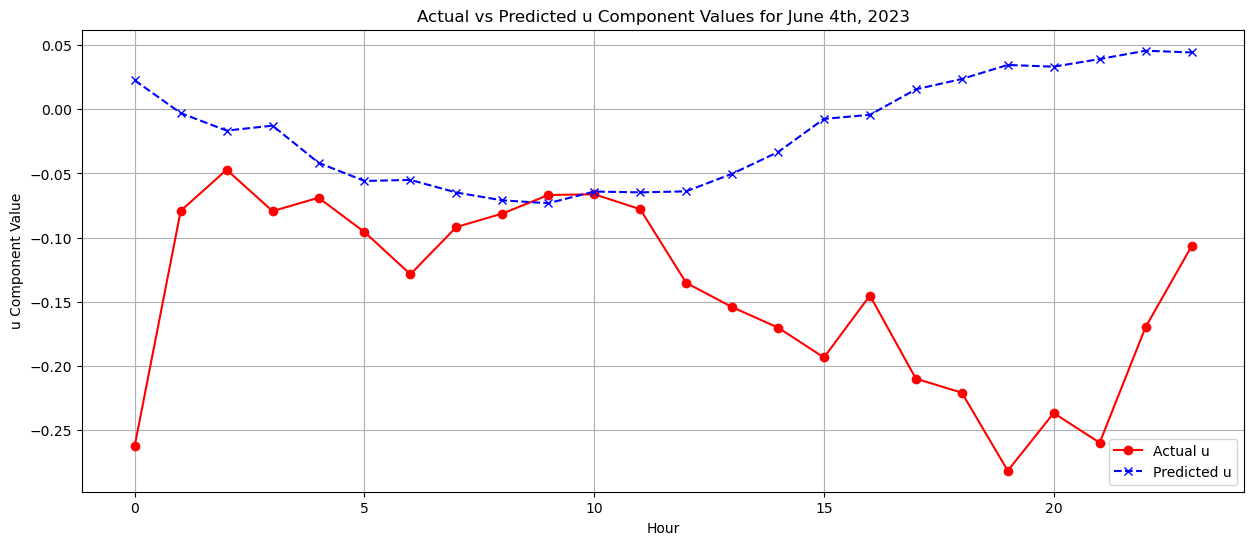

Mean Absolute Error: 0.12571981549263
Root Mean Squared Error: 0.1622646301984787


In [20]:
# Convert the last 72 hours into the model's expected input format
model_input = np.array([[df_point_input['u'].values[-72:], df_point_input['v'].values[-72:]]]).transpose(0, 2, 1)

# Load the trained model
model = load_model("Data/LSTM/Saved_Models/lstm_test")

# Make the prediction
predicted_u_values = model.predict(model_input)

actual_u_values = df_point_actual['u'].values 

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate error metrics
mae = mean_absolute_error(actual_u_values, predicted_u_values.flatten())
rmse = mean_squared_error(actual_u_values, predicted_u_values.flatten(), squared=False)

# Plotting the actual vs predicted values
plt.figure(figsize=(15, 6))
plt.plot(actual_u_values, label='Actual u', marker='o', linestyle='-', color='red')
plt.plot(predicted_u_values.flatten(), label='Predicted u', marker='x', linestyle='--', color='blue')
plt.title('Actual vs Predicted u Component Values for June 4th, 2023')
plt.xlabel('Hour')
plt.ylabel('u Component Value')
plt.legend()
plt.grid(True)
plt.show()

# Print out error metrics
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')